# Second task, magnetization part
In this notebook I show the training of the MLP to predict the magnetization of the Spin Glass. 
The structure of the notebook is the same of the one for the energy part, with minimal changes into the functions (e.g. the loading of the right dataset, the plots and axis labels ...) in order to adapt to the task.


### Table of contents:
1. [Dataset preparation](#dataset)
2. [Model and functions definitions](#model)
3. [Training of the model](#training)


In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F

import torchsummary

import os 

#import standard Dataloader

from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

Device:  cuda


In [2]:
# set standard dimensions for the plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14


# Dataset preparation  <a class="anchor" id="dataset"></a>

In order to train a MLP, we need extract the adjacency matrix and the nodes features from the graphs and store them into a 1D tensor.

Of course, in this case the edges' weights are not needed, but in order to use the same data both on GNN and MLP, I decided not to remove them.

In [3]:
# parameters for the dataset
n_nodes = 10
h = 5   # not needed for magnetization
n_samples = 5000

n_dimensions = 5
periodic = True

path = f"datasets"

#load the dataset from task 1, this time the one with the magnetization
dataset = torch.load(f"{path}/dataset_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
graphs = torch.load(f"{path}/graphs_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")


In [4]:
# preapare the data for the MLP
features = []
labels = []

for data, graph in zip(dataset, graphs):
    X = data.x
    A = nx.adjacency_matrix(graph).toarray()
    features.append(torch.cat((X, torch.tensor(A).float() ), dim=1))
    labels.append(data.y)

# print features[0] 
print("input feature: ")
print(features[0].detach().numpy().round(2))

print("label: ")
print(labels[0].detach().numpy())

input feature: 
[[-1.    0.   -0.26 -0.16 -0.85  0.45 -0.26  0.95  0.85  0.85  0.75]
 [-1.   -0.26  0.   -0.52  0.9  -0.06  0.16 -0.29  0.9   0.28  0.54]
 [-1.   -0.16 -0.52  0.    0.05  0.3  -0.65  0.28 -0.5  -0.89  0.35]
 [ 1.   -0.85  0.9   0.05  0.   -0.58  0.48  0.81  0.69  0.9   0.65]
 [ 1.    0.45 -0.06  0.3  -0.58  0.   -0.32 -0.99  0.17  0.05 -0.22]
 [ 1.   -0.26  0.16 -0.65  0.48 -0.32  0.    0.31 -0.46  0.45 -0.24]
 [-1.    0.95 -0.29  0.28  0.81 -0.99  0.31  0.   -0.53 -0.55  0.34]
 [-1.    0.85  0.9  -0.5   0.69  0.17 -0.46 -0.53  0.   -0.12 -0.21]
 [-1.    0.85  0.28 -0.89  0.9   0.05  0.45 -0.55 -0.12  0.    0.4 ]
 [-1.    0.75  0.54  0.35  0.65 -0.22 -0.24  0.34 -0.21  0.4   0.  ]]
label: 
[-4.]


In [5]:
 
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig


def train_MLP(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            # add the batch to the device
            #mini_batch.to(device)
            # train the model
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                #mini_batch.to(device)
                data = mini_batch[0]
                labels = mini_batch[1]
                data, labels = data.to(device), labels.to(device)

                prediction = model.forward(data)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, labels).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

# Model and functions definitions <a class="anchor" id="model"></a>
In this section I've defined the function used to build the MLP model and train it. 

In [6]:
# create a feedforward MLP

class MLP(torch.nn.Module):
    """
    A simple feedforward neural network with a tunable number of hidden layers
    inputs:
    - in_channels: number of input features
    - hidden_channels_1: number of neurons in the first hidden layer
    - hidden_channels_2: number of neurons in the second hidden layer
    - hidden_channels_3: number of neurons in the third hidden layer
    - out_channels: number of output features
    - dropout: dropout rate
    - lr: learning rate
    - wd: weight decay
    - hidden_layers: number of hidden layers

    outputs:
    - forward pass
    - train_step

    """
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3, out_channels=1, dropout=0.2, lr = 0.01, wd = 0.0005, hidden_layers = 2):
        super(MLP, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels_1)
        self.lin2 = Linear(hidden_channels_1, hidden_channels_2)
        self.lin3 = Linear(hidden_channels_2, hidden_channels_3)
        self.lin4 = Linear(hidden_channels_3, out_channels)

        self.dropout = torch.nn.Dropout(dropout)


        self.hidden_layers = hidden_layers           # tunable number of hidden layers 
        self.hidden_channels_2 = hidden_channels_2
        self.hidden_channels_3 = hidden_channels_3

        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr , weight_decay= wd)

    def forward(self, x):

        #print(f"Input size: {x.shape}")
        
        x = F.relu(self.lin1(x))
        #print(f"Layer 1 output size: {x.shape}")

        x = self.dropout(x)
        x = F.relu(self.lin2(x))
        #print(f"Layer 2 output size: {x.shape}")

        if self.hidden_layers ==2:
            x = self.dropout(x)
            x = F.relu(self.lin3(x))
            #print(f"Layer 3 output size: {x.shape}")
        
        elif self.hidden_channels_2 != self.hidden_channels_3:
            print("Error: hidden_channels_2 != hidden_channels_3")
            return None

        x = self.dropout(x)
        x = self.lin4(x)
        #print(f"Output size: {x.shape}")

        return x
    
    def train_step(self, data):
        # load the data into the device
        input_data = data[0].to(device)
        label = data[1].to(device)

        #print(f"input data: {input_data.shape} \n label: {label.shape} \n")
        
        # reset the gradients
        self.optimizer.zero_grad()

        # forward pass
        output = self.forward(input_data)

        # reshape the output and the label
        #output = output.view(-1)
        #label = label.view(-1)
        #print(f"output: {output} \n label: {label} \n")
        
        # compute the loss
        loss = self.criterion(output, label)
        # backward pass
        loss.backward()
        # update the weights
        self.optimizer.step()

        return loss.item()


In [14]:
# training parameters

# set standard parameters for the model

# parameters for the dataset
batchsize = 32

# parameters for the model
num_epochs = 200
lr = 1e-3
weight_decay = 1e-4
dropout = 0.4
patience = 20

# parameters for the layers
# input channels = 110
hidden_channels_1 = 64
hidden_channels_2 = 64
hidden_channels_3 = 32

hidden_layers = 2  # 1 or 2



In [15]:
# create dataloaders for the training and the test set, converting the features into a 1d tensor

features = [torch.flatten(f) for f in features]
labels = [torch.flatten(l) for l in labels]  # it should be already a 1d tensor

# split the dataset into training and test set
n_train = int(0.8*len(features))
n_test = len(features) - n_train

train_dataset = TensorDataset(torch.stack(features[:n_train]), torch.stack(labels[:n_train]))
test_dataset = TensorDataset(torch.stack(features[n_train:]), torch.stack(labels[n_train:]))

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)



In [16]:
model = MLP(in_channels=features[0].shape[0],   # flatten the input
            hidden_channels_1=hidden_channels_1, 
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            out_channels=1,
            dropout=dropout,
            lr=lr,
            wd=weight_decay,
            hidden_layers=hidden_layers
            )

model.to(device)

torchsummary.summary(model, input_size=(features[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           7,104
           Dropout-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


# Training of the model <a class="anchor" id="training"></a>

Here we shouldn't expect differences between the changing of dimensions, since the network should understand to set to zero the weights connected with the connections between the spins.

In [17]:
#train the model
model_name = f"MLP_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{dropout}_{lr}_{weight_decay}"
train_losses, test_losses = train_MLP(model, train_loader, test_loader, num_epochs, patience, model_name=model_name, verbose = True, device= device)

Training ...
Ep 1 	| Loss 6.89257 	| Test Loss 1.83524
Ep 2 	| Loss 1.53378 	| Test Loss 1.35502
Ep 3 	| Loss 1.23724 	| Test Loss 1.14294
Ep 4 	| Loss 1.1722 	| Test Loss 1.07638
Ep 5 	| Loss 1.0151 	| Test Loss 0.98665
Ep 6 	| Loss 1.0744 	| Test Loss 1.02801
Ep 7 	| Loss 0.99545 	| Test Loss 0.91464
Ep 8 	| Loss 0.91866 	| Test Loss 0.87244
Ep 9 	| Loss 0.93186 	| Test Loss 0.94282
Ep 10 	| Loss 0.97139 	| Test Loss 0.93955
Ep 11 	| Loss 0.88927 	| Test Loss 0.84245
Ep 12 	| Loss 0.88067 	| Test Loss 0.91647
Ep 13 	| Loss 0.91988 	| Test Loss 0.83978
Ep 14 	| Loss 0.91785 	| Test Loss 0.87999
Ep 15 	| Loss 0.83358 	| Test Loss 0.75855
Ep 16 	| Loss 0.85283 	| Test Loss 0.76507
Ep 17 	| Loss 0.85339 	| Test Loss 0.809
Ep 18 	| Loss 0.84362 	| Test Loss 0.87317
Ep 19 	| Loss 0.85078 	| Test Loss 0.89303
Ep 20 	| Loss 0.80099 	| Test Loss 0.83837
Ep 21 	| Loss 0.79412 	| Test Loss 0.73756
Ep 22 	| Loss 0.82249 	| Test Loss 0.71639
Ep 23 	| Loss 0.81127 	| Test Loss 0.88778
Ep 24 	| Los

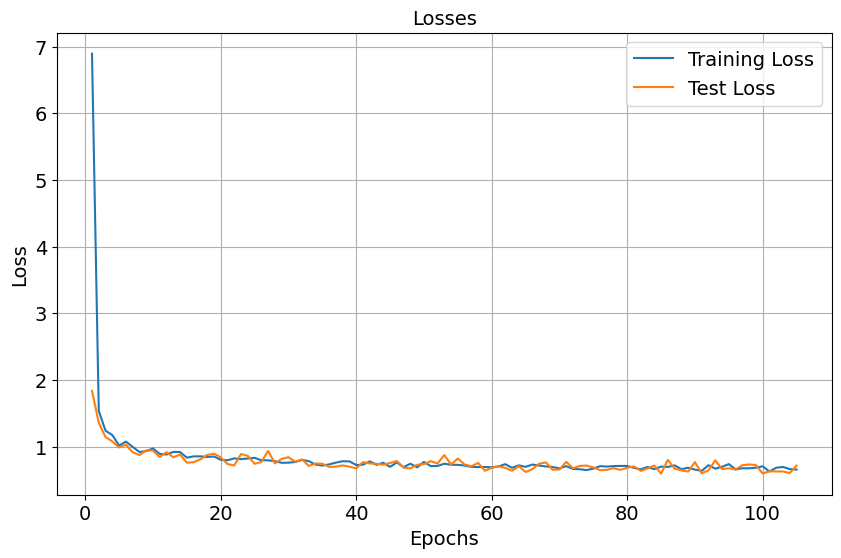

In [18]:
# plot the losses
fig = plot_loss(train_losses, test_losses)
fig.savefig(f"{model_name}_loss.png")

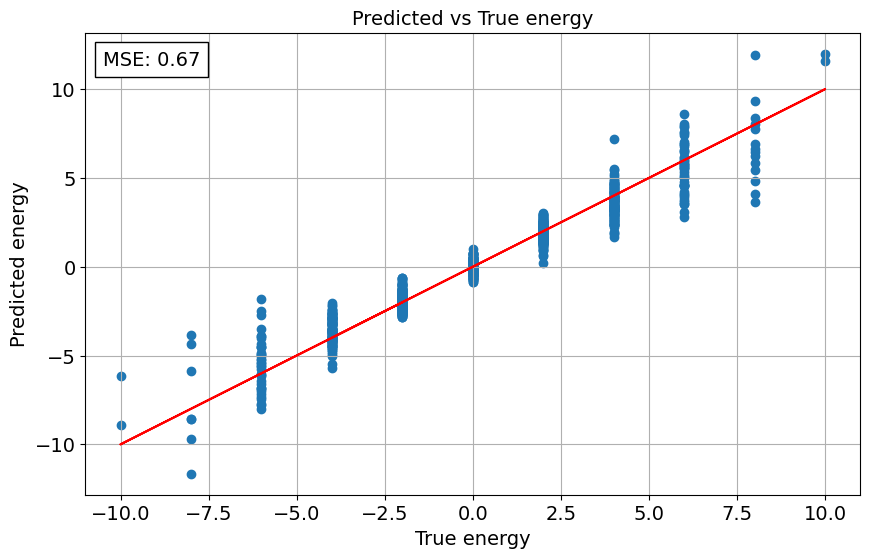

<Figure size 1000x600 with 0 Axes>

In [19]:
# show the scatter plot of the predictions
#set seed
torch.manual_seed(42)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
true_value = []

for i, mini_batch in enumerate(test_loader):
    data = mini_batch[0]
    true_value.append(mini_batch[1])
    data = data.to(device)
    prediction = model.forward(data)
    predictions.append(prediction)

predictions = torch.cat(predictions).to("cpu").detach().numpy()
true_value = torch.cat(true_value).detach().numpy()

# save the mean squared error
mse = np.mean((np.array(predictions) - np.array(true_value))**2).round(2)

plt.scatter(true_value, predictions)
plt.plot(true_value, true_value, color='red')
plt.xlabel('True energy')
plt.ylabel('Predicted energy')
plt.title('Predicted vs True energy')

at = AnchoredText(f"MSE: {str(mse)}", frameon=True, loc='upper left')
plt.gca().add_artist(at)

# plot a box similar to the legend to show the MSE
plt.grid(True)
plt.show()

# save the plot
plt.savefig(f"{model_name}_scatter.png")
    